# Import needed modules

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [82]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get Data

In [83]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


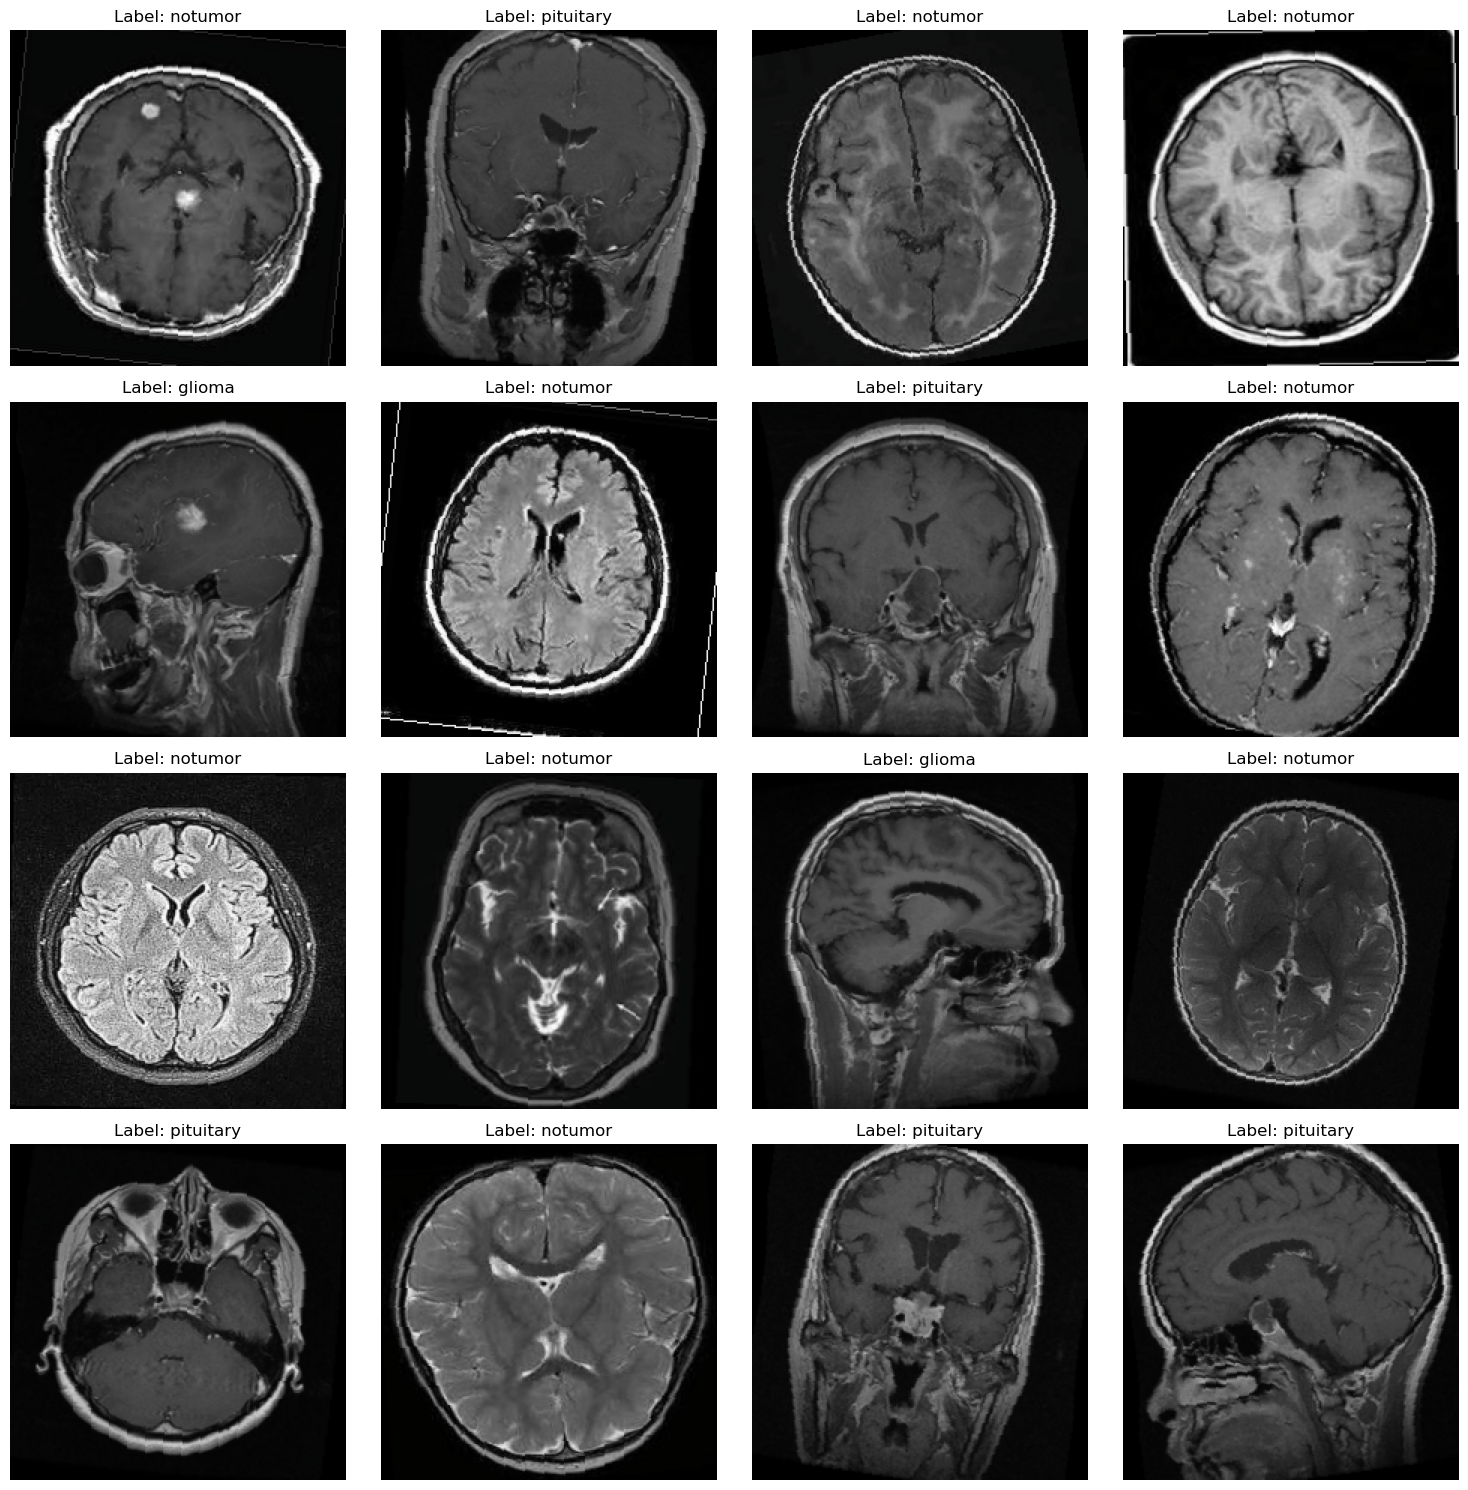

In [84]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [96]:
import torch.nn as nn
import torchvision.models as models

class HybridViTGRUClassifier(nn.Module):
    def __init__(self, num_classes, vit_model_name='vit_base_patch16_224', gru_hidden_size=128, dropout=0.5, patch_size=8):
        super(HybridViTGRUClassifier, self).__init__()

        # Load a pre-trained Vision Transformer model (ViT)
        self.vit = create_model(vit_model_name, pretrained=True, num_classes=0)  # Exclude final head
        self.vit_head_in_features = self.vit.num_features  # Typically 768 for ViT Base
        self.vit.head = nn.Identity()  # Removing the classifier head
        
        # Fine-tuning ViT: unfreeze transformer layers after some initial layers
        for param in self.vit.parameters():
            param.requires_grad = False  # Freeze all parameters
        for param in self.vit.blocks[6:].parameters():  # Fine-tune the last layers (for example)
            param.requires_grad = True

        # GRU layer for sequential modeling
        self.gru = nn.GRU(input_size=self.vit_head_in_features, 
                          hidden_size=gru_hidden_size, 
                          num_layers=2, 
                          batch_first=True, 
                          dropout=dropout, 
                          bidirectional=True)
        
        # Layer Normalization for better training stability
        self.layer_norm = nn.LayerNorm(gru_hidden_size * 2)

        # Final fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Linear(gru_hidden_size * 2, 512),  # GRU is bidirectional
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x should have shape (batch_size, sequence_length, channels, height, width)
        batch_size, seq_len, channels, height, width = x.shape
        
        # Extract features from each image using the ViT model
        vit_features = []
        for i in range(seq_len):
            vit_output = self.vit(x[:, i, :, :, :])  # Shape: (batch_size, vit_features)
            vit_features.append(vit_output.unsqueeze(1))  # Add seq_len dimension
        vit_features = torch.cat(vit_features, dim=1)  # Shape: (batch_size, seq_len, vit_features)

        # Pass the features through the GRU
        gru_out, _ = self.gru(vit_features)  # GRU output shape: (batch_size, seq_len, hidden_size * 2)

        # Layer normalization applied on GRU output
        gru_out_last = self.layer_norm(gru_out[:, -1, :])  # Shape: (batch_size, hidden_size * 2)

        # Pass the GRU output through the fully connected layers
        output = self.fc(gru_out_last)
        
        return output

model = HybridTumorClassifier(num_classes=4)
# Load a pre-trained ResNet model and modify the classifier
model.to(device)

HybridTumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [97]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [98]:
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [102]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

num_epochs = 10

# Store metrics for plotting
train_precisions, train_recalls, train_f1_scores, val_precisions, val_recalls, val_f1_scores = [], [], [], [], [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # Training phase
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:  # train_loader should be defined
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * inputs.size(0)

        # Store predictions and labels for later metric calculations
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training loss
    train_loss = running_loss / len(train_loader.dataset)

    # Calculate metrics
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='macro')  # Adjust to the appropriate average method
    train_recall = recall_score(all_labels, all_preds, average='macro')  # Adjust as needed
    train_f1 = f1_score(all_labels, all_preds, average='macro')  # Adjust as needed

    # Store training metrics
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1:.4f}')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_all_labels = []
    val_all_preds = []

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:  # val_loader should be defined
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Update running loss
            val_running_loss += loss.item() * inputs.size(0)

            # Store predictions and labels for later metric calculations
            _, preds = torch.max(outputs, 1)
            val_all_labels.extend(labels.cpu().numpy())
            val_all_preds.extend(preds.cpu().numpy())

    # Calculate validation loss
    val_loss = val_running_loss / len(val_loader.dataset)

    # Calculate metrics
    val_accuracy = accuracy_score(val_all_labels, val_all_preds)
    val_precision = precision_score(val_all_labels, val_all_preds, average='macro')  # Adjust as needed
    val_recall = recall_score(val_all_labels, val_all_preds, average='macro')  # Adjust as needed
    val_f1 = f1_score(val_all_labels, val_all_preds, average='macro')  # Adjust as needed

    # Store validation metrics
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}')




Epoch 1/10
Training Loss: 0.2576, Training Accuracy: 0.9063, Precision: 0.9031, Recall: 0.9025, F1-score: 0.9027
Validation Loss: 0.2282, Validation Accuracy: 0.9191, Precision: 0.9171, Recall: 0.9133, F1-score: 0.9146
Epoch 2/10
Training Loss: 0.2541, Training Accuracy: 0.9062, Precision: 0.9031, Recall: 0.9025, F1-score: 0.9027
Validation Loss: 0.2335, Validation Accuracy: 0.9237, Precision: 0.9232, Recall: 0.9186, F1-score: 0.9203
Epoch 3/10
Training Loss: 0.2304, Training Accuracy: 0.9128, Precision: 0.9105, Recall: 0.9091, F1-score: 0.9096
Validation Loss: 0.2416, Validation Accuracy: 0.9169, Precision: 0.9149, Recall: 0.9105, F1-score: 0.9113
Epoch 4/10
Training Loss: 0.2410, Training Accuracy: 0.9102, Precision: 0.9071, Recall: 0.9069, F1-score: 0.9069
Validation Loss: 0.2561, Validation Accuracy: 0.9146, Precision: 0.9165, Recall: 0.9088, F1-score: 0.9106
Epoch 5/10
Training Loss: 0.2388, Training Accuracy: 0.9139, Precision: 0.9118, Recall: 0.9105, F1-score: 0.9109
Validation 

# Model Evaluation

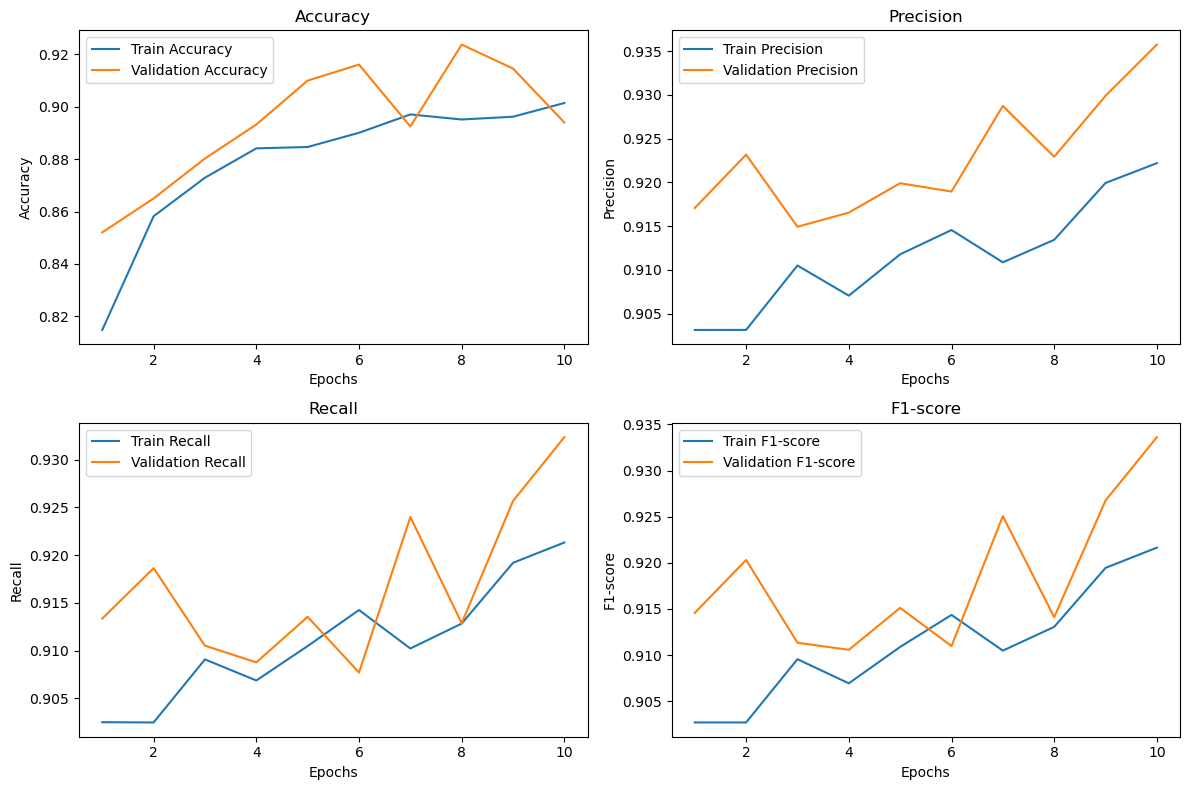

In [105]:
# Plot metrics
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_precisions, label='Train Precision')
plt.plot(epochs_range, val_precisions, label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 3)
plt.plot(epochs_range, train_recalls, label='Train Recall')
plt.plot(epochs_range, val_recalls, label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plot F1-score
plt.subplot(2, 2, 4)
plt.plot(epochs_range, train_f1_scores, label='Train F1-score')
plt.plot(epochs_range, val_f1_scores, label='Validation F1-score')
plt.title('F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()

plt.tight_layout()
plt.show()

# Saving Model

In [106]:
torch.save(model.state_dict(), 'best_model.pth')
print('Model Saved Sucssfully !')

Model Saved Sucssfully !
